In [1]:
import os
import time
import errno
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import gzip
import base64
import pickle

from numpy import mean
from log_parser import log_parser
from mpl_toolkits.mplot3d import Axes3D

try:
    from StringIO import StringIO
except ModuleNotFoundError:
    # Python 3.
    from io import StringIO

# Settings of Jupyter notebook HTML

In [2]:
from IPython.core.display import display, HTML

display(HTML("<style>.container { width: 100% !important; }</style>"))
display(HTML("<style>.container { font-size: 9.5px; !important; }</style>"))
display(HTML("<style>.rendered_html { font-size: 15px; color: red; }</style>"))
display(HTML("<style>.rendered_markdown { color: red; }</style>"))

# Initialization
### Pathes

In [3]:
default_file_name = 'dumpState.log'
file_name = 'G981V_TIE_3GMEM_30CPU_dumpstate_bottleneck_hint.txt'

#lp = log_parser('/home/ubuntu/Android/lisa_old/ipynb/performance/testingdata/dumpState_1593794288665.log')
lp = log_parser('/home/ubuntu/Android/lisa_old/ipynb/performance/testingdata/{}'.format(default_file_name))
ssrm = log_parser('/home/ubuntu/Android/lisa_old/ipynb/performance/testingdata/SSRM.log')

Reading /home/ubuntu/Android/lisa_old/ipynb/performance/testingdata/dumpState.log file is completed with 839224 lines

Reading /home/ubuntu/Android/lisa_old/ipynb/performance/testingdata/SSRM.log file is completed with 101 lines



### Values

In [4]:
pData1 = [
    'MEMORY INFO', 
    'MEMSIZE INFO',
    'MEMLOGGER DUMPSTATE',
    'SERVICE CRITICAL cpuinfo',
    'SERVICE CRITICAL SurfaceFlinger',
    'compressed core&heap dump',
    'SYSTEM LOG',
    'EVENT LOG',
    'KERNEL LOG',
    'SEC LOG',
    'LAST KMSG',
    'AP RESET INFO',
    'FILESYSTEMS & FREE SPACE',
    'SERVICE content',
    'SERVICE dropbox',
    'SERVICE accessibility',
    'SERVICE batterystats',
    'SERVICE HIGH meminfo',
    'SERVICE package',
    'SERVICE wifi',
    'SERVICE procstats',
    'OLOG',
    'ACTIVITY MANAGER MARs',
    'ACTIVITY MANAGER PENDING INTENTS',
    'ACTIVITY MANAGER BROADCAST STATE',
    'ACTIVITY MANAGER LMK KILLS',
    'ACTIVITY MANAGER RUNNING PROCESSES',
    'ACTIVITY MANAGER MARs',
    'STORAGE BUFFER',
    'SYSTEM PROPERTIES',
    'CPU INFO',
    'VM TRACES JUST NOW',
    'MMC blk0 error',
    'MMC blk1 error',
    'DUMP OF SERVICE binder_calls_stats',
    'DUMP OF SERVICE connmetrics',
    'DUMP OF SERVICE gfxinfo',
    'DUMP OF SERVICE display',
    'DUMP OF SERVICE telephony.registry',
    'DUMP OF SERVICE wifiscanner',
    'DUMP OF SERVICE binder_calls_stats',
    'DUMP OF SERVICE settings',
    'DUMP OF SERVICE scontext',
    'DUMP OF SERVICE sdhms',
    'DUMP OF SERVICE input_method',
    'DUMP OF SERVICE CRITICAL SurfaceFlinger',
    'DUMP OF SERVICE desktopmode',
    'DUMP OF SERVICE fingerprint',
    'DUMP OF SERVICE gamemanager',
    'DUMP OF SERVICE package',
    'LOG STATISTICS',
    'TSP RAW DATA',
    'beginning of main',
    'beginning of radio',
    'STORAGED IO INFO',
    'PowerAnomaly Battery Dump',
    'UFS ERR SUM',
    'UFS FATAL CNT',
    'UFS OP CNT',
    'UFS QUERY CNT',
    'UFS UIC CMD CNT',
    'UFS UIC ERR CNT',
    'NETWORK DEV INFO',
    'PROCESSES AND THREADS',
    'RADIO LOG',
    'APP SERVICES PLATFORM',
    'APP SERVICES NON-PLATFORM',
    'APP PROVIDERS NON-PLATFORM',
]

lp.run(arg1=pData1)

#display(lp.log_sections['DUMP OF SERVICE binder_calls_stats'])

### Functions

In [5]:
def grep(lines, searchers, n=99999, show=True):
    result = list()
    number_of_lines = 0
    number_of_negative_lines = 0
    negative_lines = list()

    if n < 0:
        number_of_negative_lines = (-1) * n
        
    for line in lines:
        if len(line) > 0:
            for searcher in searchers:
                if re.search(searcher, line):
                    if n >= 0:
                        number_of_lines = n
                    else:
                        for negative_line in negative_lines:
                            if show:
                                print(negative_line.strip())
                            result.append(negative_line.strip())
                        if show:
                            print(line)
                        result.append(line.strip())
                        
            if number_of_lines > 0:
                if show:
                    print(line.strip())
                result.append(line.strip())
                number_of_lines -= 1
                #if number_of_lines == 0:
                    #print("\n")
                    #result.append('')

            if number_of_negative_lines > 0:
                negative_lines.append(line)
                number_of_negative_lines -= 1
            elif n < 0:
                negative_lines.pop(0)
                negative_lines.append(line)
                
    if len(result) == 0:
        print("--- Nothing ---")
        
    return result

In [6]:
def pickedup(src, searcher, index=0):
    separators = ['/', ',', ' ']
    
    if searcher not in src:
        return None
    
    splited = src.split(searcher)
    if splited <= 0:
        return None
    
    numbers = re.findall('-?\d+', splited[1])
    if len(numbers) > index:
        return int(numbers[index])
    
    return None

In [7]:
def DictFromPickedUp(src, searchers):
    result = dict()
    for key in searchers.keys():
        result[key] = list()

    tmp = dict()
    for line in src:
        flag = False
        for key in searchers.keys():
            tmp[key] = pickedup(line, key, searchers[key])
            if tmp[key] is None:
                flag = True

        if flag == True:
            continue

        for key in searchers.keys():
            result[key].append(tmp[key])
            
    return result

In [8]:
def orderbyeq(src, index=0):
    result = dict()
    items = re.split('[ ]', src)
    for item in items:
        if '=' in item and item[0] == '[':
            item = item[1:]
            splited = item.split('=')
            key = splited[0]
            numbers = re.findall('\d+', splited[1])
            if numbers > 0:
                result[key] = int(numbers[0])
                
    return result

In [9]:
def DataframeFromDictSortByCount(rawdata):
    df = pd.DataFrame.from_dict(rawdata, orient='index')
    df['count'] = df.count(axis=1, numeric_only=True)
    df = df.sort_index(by='count', axis=0, ascending=False)
    df = df.drop(columns=['count'])    
    return df

In [10]:
def PlotFromDict(rawdata, threshold, title='', ylabel=''):
    df = pd.DataFrame.from_dict(rawdata, orient='index')
    for key in df.index:
        if max(rawdata[key]) > threshold:
            s = pd.Series(rawdata[key])
            ax = s.plot(figsize=(30,5), label=key, legend=True)
            ax.axhline(y=threshold, xmin=-1, xmax=1, color='r', linestyle='--', lw=2)
            ax.set_title(title)
            ax.set_ylabel(ylabel)

In [11]:
def MarkupLCDON(lines):
    LCD_ON = list()
    marker = ''
    for line in lines:
        if re.search('LCD', line):
            if re.search(' ON ', line):
                LCD_ON.append(line)
                marker = ' LCDON >>> '
                print(line)
            elif re.search(' OFF ', line):
                LCD_ON.append(line)
                marker = ''
                print(line)
        else:
            LCD_ON.append(marker + line)
            print(marker + line)
    return LCD_ON

In [12]:
def str2num(string):
    try:
        number = int(string)
    except:
        number = -1
        
    return number

def GetTime(line, type=None):
    Days = [0, 31, 29, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
    splited_items = line.split(' ')
    Date = 0
    for item in splited_items:
        if Date == 0:
            if len(item) > 4 and item[-3] is '-':
                Month = str2num(item[-5:-3])
                Day = str2num(item[-2:])
                if Month >= 0 and Day >= 0 :
                    Date = (Days[Month] + Day) * 24 * 60 * 60 * 1000
        else:
            if type is 'SSRM':
                item += '.000'

            if len(item) > 11 and item[2] is ':' and item[5] is ':' and item[8] is '.':
                Hour = str2num(item[0:2])
                Minute = str2num(item[3:5])
                Second = str2num(item[6:8])
                MiliSecond = str2num(item[9:12])
                if Hour >= 0 and Minute >= 0 and Second >= 0 and MiliSecond >= 0:
                    return Date + ((Hour * 60 + Minute) * 60 + Second) * 1000 + MiliSecond
            Date = 0
            
    return -1

def GetTime2(line, type=None):
    Days = [0, 31, 29, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
    splited_items = line.split(' ')
    Date = 0
    for item in splited_items:
        if Date == 0:
            if len(item) > 4 and item[-3] is '-':
                Month = str2num(item[-5:-3])
                Day = str2num(item[-2:])
                if Month >= 0 and Day >= 0 :
                    TotalDays = 0
                    for i in range(1, Month):
                        TotalDays += Days[i]
                    Date = (TotalDays + Day) * 24 * 60 * 60 * 1000
        else:
            if type is 'SSRM':
                item += '.000'

            if len(item) > 11 and item[2] is ':' and item[5] is ':' and item[8] is '.':
                Hour = str2num(item[0:2])
                Minute = str2num(item[3:5])
                Second = str2num(item[6:8])
                MiliSecond = str2num(item[9:12])
                if Hour >= 0 and Minute >= 0 and Second >= 0 and MiliSecond >= 0:
                    return Date + ((Hour * 60 + Minute) * 60 + Second) * 1000 + MiliSecond
            Date = 0
            
    return -1

def GetKernelTime(line):
    splited = line.split('[')
    splited = splited[1].split(']')
    splited = splited[0].split('.')

    second = str2num(splited[0])
    if second < 0:
        return -1
    
    nanosecond = str2num(splited[1])
    if nanosecond < 0:
        return -1
    
    return (int)(second * 1000 + (int)(nanosecond / 1000))

In [13]:
def GetSsrmDump(lines):
    CompressedEncriptedStr = ""
    flag = False

    for line in lines:
        if 'SSRM MEMORY DUMP' in line and flag is True:
            Trimed = line[:-1]
            CompressedEncriptedStr += Trimed
            break

        if flag is True :
            Trimed = line[:-1]
            #zlib.decompress(Trimed, 16+zlib.MAX_WBITS)
            #Unziped = gz.decompress(Trimed).decode()
            #Unziped = gzip.GzipFile(fileobj=Trimed)
            #CompressedEncriptedStr.append(Unziped)
            #print(Unziped)
            CompressedEncriptedStr += Trimed

        if 'SSRM MEMORY DUMP' in line and flag is False:
            flag = True

    if "SSRM MEMORY DUMP" in CompressedEncriptedStr:
        CompressedEncriptedStr = CompressedEncriptedStr.split("SSRM MEMORY DUMP")[0]

    return CompressedEncriptedStr

In [14]:
def DecodeSsrm(CompressedEncriptedStr):
    Decoded = base64.b64decode(CompressedEncriptedStr)       

    sfp = StringIO()
    sfp.write(Decoded)
    sfp.seek(0)
    gfp = gzip.GzipFile(fileobj=sfp, mode='rb')
    uncompressed = gfp.read()
    sfp.close()
    gfp.close()

    try:
        del ssrm_list[:]
    except:
        print("---")
    ssrm_list = uncompressed.split('\n')
    
    return ssrm_list

In [15]:
lines = lp.log_sections['DUMP OF SERVICE sdhms']
#file_lines
CompressedEncriptedStr = GetSsrmDump(lines)

if len(CompressedEncriptedStr) > 0:
    ssrm.file_lines = DecodeSsrm(CompressedEncriptedStr)
    display(ssrm.file_lines)
else:
    display("SSRM file was loaded.")

'SSRM file was loaded.'

In [16]:
if len(CompressedEncriptedStr) is 0:
    CompressedEncriptedStr = GetSsrmDump(lp.file_lines)
    
    if len(CompressedEncriptedStr) > 0:
        ssrm.file_lines = DecodeSsrm(CompressedEncriptedStr)
        #display(ssrm.file_lines)
        display("SSRM MEMORY data was parsed.")
    else:
        display("SSRM file was loaded.")

---


'SSRM MEMORY data was parsed.'

In [17]:
def ConvertEsternArabicToWestern(EsternStr) :
    buckArab = {"'":"ء", "|":"آ", "?":"أ", "&":"ؤ", "<":"إ", "}":"ئ", "A":"ا", "b":"ب", "p":"ة", "t":"ت", "v":"ث", "g":"ج", "H":"ح", "x":"خ", "d":"د", "*":"ذ", "r":"ر", "z":"ز", "s":"س", "$":"ش", "S":"ص", "D":"ض", "T":"ط", "Z":"ظ", "E":"ع", "G":"غ", "_":"ـ", "f":"ف", "q":"ق", "k":"ك", "l":"ل", "m":"م", "n":"ن", "h":"ه", "w":"و", "Y":"ى", "y":"ي", "F":"ً", "N":"ٌ", "K":"ٍ", "~":"ّ", "o":"ْ", "u":"ُ", "a":"َ", "i":"ِ", "0":"٠", "1":"١", "2":"٢", "3":"٣", "4":"٤", "5":"٥", "6":"٦", "7":"٧", "8":"٨", "9":"٩"}
    WesternStr  = list()
    for line in EsternStr:
        for k, v in buckArab.iteritems():
            #print("{}  -  {}".format(k, v))
            line = line.replace(v, k)  
                
        WesternStr.append(line)            

    return WesternStr

ssrm.file_lines = ConvertEsternArabicToWestern(ssrm.file_lines)

In [18]:
if len(ssrm.file_lines):
    ssrm_head = list()
    ssrm_contextA = list()
    ssrm_contextB = list()
    ssrm_tail = list()
    ssrm_step = 0
    ssrm_time = 0
    ssrm_previous_time = 0

    for line in ssrm.file_lines:
        ssrm_time = GetTime2(line, 'SSRM')
        if ssrm_step is 0:
            if (ssrm_time < 0):
                ssrm_head.append(line)
            else:
                ssrm_step += 1

        if ssrm_step is 1:
            if (ssrm_previous_time - 10000) <= ssrm_time:
                ssrm_contextA.append(line)
                #print("STEP1  {} {} - {}".format(ssrm_previous_time, ssrm_time, line))
            else:
                ssrm_step += 1

        if ssrm_step is 2:
            if (ssrm_time > 0):
                ssrm_contextB.append(line)
                #print("STEP2  {} {} - {}".format(ssrm_previous_time, ssrm_time, line))
            else:
                ssrm_step += 1            

        if ssrm_step is 3:
            ssrm_tail.append(line)
            
        ssrm_previous_time = ssrm_time

    ssrm.file_lines = ssrm_head + ssrm_contextB + ssrm_contextA + ssrm_tail
    
    file = open('/home/ubuntu/Android/lisa_old/ipynb/performance/testingdata/SSRM_.log', 'w+')
    for line in ssrm.file_lines:
        file.writelines(line + '\n')
        print(line)
    file.close()
    #display(ssrm.file_lines)

SSRM SETTINGS ENGINE
TOP DUMP Based on SIOP Level============================================================================================================================================================================================================
[COM] [(SIOP Level)(AP_temp,PST_temp,BAT_temp,USB_temp,CHG_temp,PA_temp,CP_temp,MMW_temp,WIFI_temp,CF_temp,BLK_temp,SUBBAT_temp,LRP_temp,LRP2_temp<LRP2_type>,(BAT_level,Inow_avg,Isys_avg)(RSSI[common,Gsm/Cdma/Lte],Radio_data,Radio_RxTput,Radio_TxTput,Wifi_data,Wifi_signal_Level,Wifi_RxTput,Wif_TxTput)(Brightness,FPS,HRR),(Vidoe_Audio,AudioDevice:Volume)]
[SET] [NDX0XWXOXXXXXXX] => [PowerSavingMode/UltraPowerSavingMode/EmgergencyMode/NormalMode, ChargingStatus(aFc, Ac, Usb, Wireless, Charge, Discharge), Cooldown, KnoxMode, Screen, AOD, AutoBright, DisplayType, HrrMode, CameraOn, MusicOn, VideoPlaying, UsbTethering, CallState, SilentLog, Radio or WiFi, BTEnable, BTConnect / WiFi Info / BT Info]
[CF:CPUFreq, GF:GPUFreq, CC:CpuCoreNum, CG:C

In [19]:
lines = lp.log_sections['SERVICE content']
tmp = grep(lines,['Uptime'], 1)

Uptime: 18d11h05m36s


* Description

The attached log was gotten right after rebooting. <br>
So, there was no useful information for analyzing the issues you were faced with.<br>
Please report the issue right after it happens without rebooting and elaborate on it. <br>
For better analysis, we need the name of application that is related to the issue and the time when it happens. <br>


로그 확인시 재부팅 직후 확보된 로그로 문제 상황을 포함하지 않은 것으로 보입니다.<br>
[문제 발생시 삼성 멤버스를 통하여 덤프와 함께 문제점 등록을 권장합니다.]<br>
삼성멤버스를 통하여 수집되는 로그는 크기가 한정되어 있어 문제 상황을 포함하지 않을 수 있으니,<br>
문제 재현시 재부팅 없이 바로 오류 보고 부탁드리며, 문제 발생 앱, 문제 발생 시각 등을 정확히 명시해 주시기 바랍니다.<br>
느림 또는 멈춤에 대해서도 보다 상세한 설명 부탁드립니다.<br>
예를 들어, 앱 진입 속도가 느림, 진입시 애니메이션이 부드럽지 않음, 앱 내부에서 스크롤이 부드럽지 않음, 게임 로딩이 느림, 게임 플레이시 부드럽지 않음, 인터넷 사용 앱에서 사진 등의 로딩이 느림 등등 구체적으로 설명해 주시면 됩니다.<br>

# <span style="color:blue">Base</span> 

2022-02-10 11:20:14

N986BXXS3EULH:user

In [20]:
file = open('problem_history.txt')

problem_history = dict()
for line in file:
    if ':' in line:
        splited = line.split(':')
        if len(splited) > 0:
            if splited[0] not in problem_history:
                problem_history[splited[0]] = list()
            problem_history[splited[0]].append(splited[1])
    #print(line)
file.close()

for history in sorted(problem_history.keys()):
    for line in problem_history[history]:
        print(history + ' : ' + line[:-1])
#display(problem_history)


F916NKSU1EULF : Unfolding시 display swap 동작이 끝나기 전에, config change 가 발생할 경우, display config 와 globla config 의 diff 가 남게 되어, waitForConfig 상태로 freeze 가 풀리지 않는 현상[P220221-03031]
F916NKSU1EVAA : Unfolding시 display swap 동작이 끝나기 전에, config change 가 발생할 경우, display config 와 globla config 의 diff 가 남게 되어, waitForConfig 상태로 freeze 가 풀리지 않는 현상[P220221-03031]
F926 : TE 신호 비정상으로 인해 20fps로 동작하는 display h/w문제 [P220224-06090, P220315-02136]
G990EXXS1BVB8 : REFRESH_RATE_MODE_NORMAL - 간헐적으로 30fps 동작하는 문제, aod 진입, REFRESH_RATE_MODE_SEAMLESS - 지문 해제후 lcd on 시 확인
G991BXXS4BVAA : REFRESH_RATE_MODE_NORMAL - 간헐적으로 30fps 동작하는 문제, aod 진입, REFRESH_RATE_MODE_SEAMLESS - 지문 해제후 lcd on 시 확인
G991BXXU4BULF : REFRESH_RATE_MODE_NORMAL - 간헐적으로 30fps 동작하는 문제, aod 진입, REFRESH_RATE_MODE_SEAMLESS - 지문 해제후 lcd on 시 확인
G991BXXU4BVB1 : REFRESH_RATE_MODE_NORMAL - 간헐적으로 30fps 동작하는 문제, aod 진입, REFRESH_RATE_MODE_SEAMLESS - 지문 해제후 lcd on 시 확인
G998BXXU4BULF : REFRESH_RATE_MODE_NORMAL - 간헐적으로 30fps 동작하는 문제, aod 진입, REFRESH_RATE_MODE_S

In [21]:
splited = lp.file_lines[1].split(' ')
dumptime = splited[2] + ' ' + splited[3][:-1]
splited = lp.file_lines[5].split('/')
version = splited[4]

print(version)
print(dumptime)

with open('version_history.pkl', 'rb') as f:
    version_history = pickle.load(f)

#version_history = dict()
if version not in version_history:
    version_history[version] = list()
if dumptime not in version_history[version]:
    version_history[version].append(dumptime)

with open('version_history.pkl', 'wb') as f:
    pickle.dump(version_history, f)

T515XXU8CVB1:user
2022-04-26 19:53:29


In [22]:
for cur_version in sorted(version_history.keys()):
    if version == cur_version:
        print('')
        print('>>> {} - {}'.format(cur_version, version_history[cur_version]))
        for problem_version in problem_history:
            if problem_version in version:
                for line in problem_history[problem_version]:
                    print('     - ' + line)
        print('')
    else:
        print('{} - {}'.format(cur_version, version_history[cur_version]))

A015MUBS4BUL1:user - ['2022-04-08 10:44:58']
A022MUBS3BVB2:user - ['2022-04-24 20:45:34']
A037MUBU2AVA6:user - ['2022-03-13 13:31:40']
A105MUBS7CUK1:user - ['2022-04-15 10:32:44', '2022-04-16 20:14:38']
A107FXXU8CUL2:user - ['2022-03-15 09:19:55']
A107MUBU5CUH1:user - ['2022-04-18 16:40:32']
A107MUBU6CVB1:user - ['2022-04-14 20:34:17']
A115MUBU2BUK4:user - ['2022-02-09 21:18:45']
A125FXXS2BVC1:user - ['2022-04-18 18:28:56']
A125FXXU2BVB3:user - ['2022-04-16 03:40:18']
A125MUBU2BVB3:user - ['2022-04-14 15:13:27']
A125USQU3BVB1:user - ['2022-04-21 21:39:58', '2022-04-24 11:03:37']
A127MUBS4AVA3:user - ['2022-04-20 13:13:54']
A127MUBU3AUJ5:user - ['2022-03-20 20:59:44']
A207MUBU3CUL1:user - ['2022-04-01 11:41:30', '2022-04-16 18:30:58']
A217FXXS7CUL2:user - ['2022-02-22 13:23:33']
A225FXXU3AVB1:user - ['2022-04-18 05:13:00']
A305GUBU8CUJ1:user - ['2022-04-15 19:48:56']
A315FXXU1CVA1:user - ['2022-02-27 06:11:33']
A315GDXS1CVB2:user - ['2022-04-14 18:06:58']
A320FLXXS9CTK3:user - ['2022-03

In [23]:
lines = lp.log_sections['DUMP OF SERVICE display']
tmp = grep(lines,['mDefaultViewport'], 1)

--- Nothing ---


###### bugreport_mode

 * BUGREPORT_DEFAULT <br>
   : adb shell bugreport
   
 * BUGREPORT_FULL<br>
   : Settings > bug report

 * BUGREPORT_INTERACTIVE<br>
   : Settings > bug report<br>
   : Settings > Bug report shortcut 

* 16xxxxxx ns : 60 hz 
* 8xxxxxx ns : 120 hz

In [24]:
lines = lp.log_sections['compressed core&heap dump']
tmp = grep(lines,['VSYNC period'], 1)
lines = lp.log_sections['SERVICE CRITICAL SurfaceFlinger']
tmp = grep(lines,['VSYNC period'], 1)

--- Nothing ---
--- Nothing ---


In [25]:
lines = lp.log_sections['SYSTEM LOG']
tmp = grep(lines,['dumpstate: begin', 'dumpstate: done', 'dumpstate info: id', 'dumpstate: do_zip_file'], 1)

04-26 19:53:29.968  root 19008 19008 I dumpstate: do_zip_file: 0 do_vibrate: 0 use_socket: 1 use_control_socket: 0 do_screenshot: 0 is_remote_mode: 0 show_header_only: 0 do_start_service: 0 telephony_only: 0 wifi_only: 0 do_progress_updates: 0 fd: -1 bugreport_mode: BUGREPORT_DEFAULT dumpstate_hal_mode: DEFAULT limited_only: 0 args: /system/bin/dumpstate -s
04-26 19:53:29.973  root 19008 19008 I dumpstate: dumpstate info: id=1, args='/system/bin/dumpstate -s', bugreport_mode= BUGREPORT_DEFAULT bugreport format version: 2.0


In [26]:
lines = lp.log_sections['SYSTEM LOG']
tmp = grep(lines,['setForcedDisplaySizeDensity'], 1)

--- Nothing ---


* the number of installed packages

In [27]:
lines = lp.log_sections['ACTIVITY MANAGER MARs']
tmp = grep(lines,['mManagedPackage'], 1)

--- Nothing ---


* debug level<br>
    high : 0x4948<br>
    mid : 0x494d<br>
    low : 0x4f4c

In [28]:
lines = lp.log_sections['SYSTEM PROPERTIES']
tmp = grep(lines,['debug_level'], 1)

--- Nothing ---


* Calculation for gap between android time and kernel time.

In [29]:
lines = lp.log_sections['KERNEL LOG']
sync_logs = grep(lines,['@Sync'], 1, show=True)

gapoftime = list()
for sync_log in sync_logs:
    androidtime = GetTime(sync_log)
    kerneltime = GetKernelTime(sync_log)

    if androidtime < 0 or kerneltime < 0:
        continue

    print("{} - {} = {}").format(androidtime, kerneltime, androidtime - kerneltime)
    gapoftime.append(androidtime - kerneltime)

GAP_OF_TIME = 0

if len(gapoftime) > 0:
    GAP_OF_TIME = int(mean(gapoftime) + 0.5)
    #display(gapoftime)
    display("Average : {}".format(GAP_OF_TIME))
    GAP_OF_TIME = gapoftime[0]
    display("Current : {}".format(GAP_OF_TIME))   

--- Nothing ---


# <span style="color:blue">CPU</span> 

The sampling time should be checked.
If the term is short, the cpu usage infor is not important.

* CPU frequency table and max frequency

In [30]:
lines = lp.log_sections['SERVICE batterystats']
CPU_freqs = grep(lines,['CPU freqs'], 1)
CPU_MAX_FREQ = 2000000

if len(CPU_freqs) > 0:
    CPU_MAX_FREQ = 0
    CPU_FREQ_TABLE = CPU_freqs[0].split(':')[1]
    for CPU_freq in CPU_FREQ_TABLE.split(' '):
        if len(CPU_freq) > 0:
            num_cpu_freq = int(CPU_freq)
            if num_cpu_freq > CPU_MAX_FREQ:
                CPU_MAX_FREQ = num_cpu_freq
    print('Max CPU Freq : ' + str(CPU_MAX_FREQ))

CPU freqs: 1586000 1482000 1352000 1248000 1144000 1014000 902000 839000 757000 676000 546000 449000 1768000 1664000 1560000 1352000 1144000 936000
Max CPU Freq : 1768000


* Sometime zygote process can have high cpu usage, when am_proc_start is working.

In [31]:
cpuinfo = lp.log_sections['SERVICE CRITICAL cpuinfo'][:15]

top_cpuinfo = ""
for item in cpuinfo:
    if '%' in item and '/' in item:
        top_cpuinfo = item
        break
        
for item in cpuinfo:
    print(item[:-1])
#display(cpuinfo)

DUMP OF SERVICE CRITICAL cpuinfo:
Load: 11.9 / 12.5 / 13.13
CPU usage from 34054ms to 19987ms ago (2022-04-26 19:52:57.855 to 2022-04-26 19:53:11.922):
  29% 18099/com.facebook.katana: 18% user + 11% kernel / faults: 11565 minor 358 major
  27% 19639/system_server: 17% user + 9.6% kernel / faults: 14697 minor 4184 major
  10% 17118/com.samsung.android.voc: 7.9% user + 2.4% kernel / faults: 16542 minor 164 major
  8.7% 3684/surfaceflinger: 3.9% user + 4.7% kernel / faults: 478 minor 8 major
  8.4% 863/kswapd0: 0% user + 8.4% kernel
  4.5% 2733/com.security.antivirus.clean: 2.8% user + 1.7% kernel / faults: 1496 minor 195 major
  4% 1700/mmc-cmdqd/0: 0% user + 4% kernel
  1.9% 19908/com.android.systemui: 1.2% user + 0.7% kernel / faults: 6108 minor 41 major
  1.7% 3607/android.hardware.graphics.composer@2.1-service: 0.4% user + 1.3% kernel / faults: 54 minor 2 major
  0.9% 1945/decon0: 0% user + 0.9% kernel
  0.9% 30922/com.google.android.gms.persistent: 0.4% user + 0.4% kernel / faults:

* FGS : ForeGroud Service<br>
* CEM : Cache EMpty<br>

In [32]:
lines = lp.log_sections['ACTIVITY MANAGER RUNNING PROCESSES']
proecss_lru_list = grep(lines,['Process LRU list'], 500, show=False)

splited_top_cpuinfo = top_cpuinfo.split(" ")
print(splited_top_cpuinfo)
uid_of_top_cpuinfo = ""
name_of_top_cpuinfo = ""
for item in splited_top_cpuinfo:
    if '/' in item:
        splited = item.split("/")
        uid_of_top_cpuinfo = splited[0]
        name_of_top_cpuinfo = splited[1]
        name_of_top_cpuinfo = name_of_top_cpuinfo[:-1]
        print("uid : [{}]".format(uid_of_top_cpuinfo))
        print("process name : [{}]\n\n".format(name_of_top_cpuinfo))
        break

#pid_of_top_cpuinfo = 13680
#name_of_top_cpuinfo = "com.google.android.webview:sandboxed_process0:org.chromium.content.app.SandboxedProcessService0"

current_process = ""
for process_lru in proecss_lru_list:
    if '#' in process_lru:
        if name_of_top_cpuinfo in current_process:
            if uid_of_top_cpuinfo in current_process:
                print('\033[31m' + 'This process had a matched uid.' + '\033[0m')
                print('\033[31m' + current_process + '\033[0m\n')
            else:
                print(current_process + "\n")
        current_process = process_lru
    else:
        current_process += "\n         " + process_lru

    if len(process_lru) is 0:
        break

['', '', '29%', '18099/com.facebook.katana:', '18%', 'user', '+', '11%', 'kernel', '/', 'faults:', '11565', 'minor', '358', 'major\n']
uid : [18099]
process name : [com.facebook.katana]




In [33]:
lines = lp.log_sections['CPU INFO']
CPU_freqs = grep(lines,['Threads'], 25)

--- Nothing ---


# <span style="color:blue">[PACKAGES]</span> 

* Installed packages and version.

In [34]:
lines = lp.log_sections['SERVICE package']
package_lines = grep(lines,['Package \[', 'versionName', 'versionCode', 'firstInstallTime', 'lastUpdateTime'], 1, show=False)

for package_line in package_lines:
    if 'Package' in package_line:
        print('')
        
    print(package_line)

--- Nothing ---


* Search the name of installed package and version.

In [35]:
tmp = grep(package_lines,['com.reddit.frontpage'], 2)

--- Nothing ---


--- Nothing ---
total 0 packages


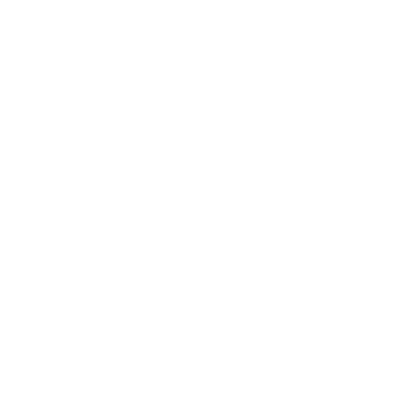

In [36]:
dexopt_lines = lp.log_sections['SERVICE package']
status_lines = grep(dexopt_lines,['status='], 1, show=False)

dexopt_state = dict()
for line in status_lines:
    if 'compilation_filter' in line:
        splited_line = line.split(',')
        status = splited_line[-1]
        dexopt_state[status] = dexopt_state.get(status, 0) + 1
    else:
        splited_line = line.split('[')
        if len(splited_line) > 0 and 'status' in splited_line[1]:         
            status = splited_line[1][:-2]
            dexopt_state[status] = dexopt_state.get(status, 0) + 1

#df.plot.pie(y='0', figsize=(5, 5), autopct='%1.1f%%', startangle=100)
print("total {} packages".format(len(status_lines)))
plt.figure(figsize=(7, 7))
plt.pie(dexopt_state.values(), labels = dexopt_state.keys(), autopct='%1.1f%%') 
plt.show() 

* DESCRIPTION

Fota 후 background dex optimization 동작 전이라, 대부분의 앱들이 [verify] 상태입니다.<br>
이 경우 method read시 마다 apk를 직접 access 후 verification, JIT 과정을 거치기에 느려질 수 있습니다.<br>
1주일이 경과하는 동안 [speed-profile] 혹은 [speed]상태로 앱 상태가 변경되고 있으나 아직 50%이상이 [verify] 상태입니다.<br>
특히, 사용빈도가 높은 편인 카톡, 갤러리 및 파일쿠키(filekukiv3) 등이 아직 [verify] 상태여서 다소 끊김등에 문제가 있을 수 있습니다.<br>
유휴시간(잠자기 전에 충전기를 연결해 놓고 아침까지 단말 방치해 놓으면)이지나면 bg dexopt 동작이 완료될 것으로 보입니다.<br>
(일반적으로 2 ~ 3 일이 소요될 수 있습니다.)<br>


조치 이후에도 여전히 느림 또는 멈춤 현상이 재현되면, <br>
문제 발생시 지체없이 오류 보고 부탁드리며, 문제 발생 앱, 문제 발생 시각 등을 정확히 명시해 주시기 바랍니다.<br>
느림 또는 멈춤에 대해서도 보다 상세한 설명 부탁드립니다.<br>
예를 들어, 앱 진입 속도가 느림, 진입시 애니메이션이 부드럽지 않음, 앱 내부에서 스크롤이 부드럽지 않음, 게임 로딩이 느림, 게임 플레이시 부드럽지 않음, 인터넷 사용 앱에서 사진 등의 로딩이 느림 등등 구체적으로 설명해 주시면 됩니다.

----------------------------------------------------------------------------------

A few apps had changed to the speed-profile or the speed status during [two weeks]  after SW update, but more than about [80%] was still in the verify status. <br>
[Gallery, chrome and facebook], which were used frequently by user, were still in the verify status.<br>

Android devices use a profile-based compilation system.<br>
This means, after SW update, the previous compilation for every single application is cleared.<br>
So, applications might be slightly slower than before for a while after SW update.<br>
But after idle time, Android system will be compiling the application again.<br>
By the way, the condition of the idle time is at least 71 minutes of charging and screen-off.<br>
Unfortunately, your charging time was usually too short. So, your device have not satisfied the condition after SW update.<br>
Please leave your device with charger when you go to sleep.<br>

A few days later, if you would still have same problem after following this guidance, <br>
please register issue again to use Samsung Members.<br>
A dumpstate collected by Samsung Members application has a limited buffer size.<br>
So, it may not include the issue that you mentioned.<br>
Please report the issue right after it happens and elaborate on it. <br>
For better analysis, we need the name of application that is related to the issue and the time when it happens. 


* kr.co.avad.diagnostictool app is used in A/S center.
* com.rsupport.rs.activity.rsupport.aas2 is remote service app.
* com.lguplus.mobile.smartcounsel is U+ customer service app.
* com.samsung.android.lool is device care app.
* com.samsung.android.sidegesturepad is one hand operation app.


In [37]:
lines = ssrm.file_lines
tmp = grep(lines,['kr.co.avad.diagnostictool', 'com.rsupport.rs.activity.rsupport.aas2', 'com.lguplus.mobile.smartcounsel', 'com.samsung.android.lool', 'com.samsung.android.sidegesturepad'], 1)

2022-04-26 19:48:35 [PKG] com.samsung.android.lool
2022-04-26 19:51:52 [PKG] com.samsung.android.lool
2022-04-26 19:51:59 [PKG] com.samsung.android.lool


In [38]:
lines = lp.log_sections['SYSTEM LOG']
tmp = grep(lines,['Choreographer: skipped'], 1)

--- Nothing ---


* Bad apps

: The PUBG game(com.tencent.ig) app have performance problem with LSI Ramen chip.

 4: name='Window{f7a5252 u0 com.autoclicker.clicker}', displayId=0, paused=false, hasFocus=false, hasWallpaper=false, visible=true, canReceiveKeys=false, flags=0x00000518, type=0x000007f6, samsungFlags=0x00000000, layer=121205, frame=[360,640][440,720], scale=1.000000, touchableRegion=[360,640][440,720], pTouchableRegion=<empty>, inputFeatures=0x00000000, ownerPid=2763, ownerUid=10837, dispatchingTimeout=5000.000ms

: The reddit app have a sluggish problm when scrolling in the app.

: Alibaba app(com.alibaba.aliexpresshd') could remove a file of mediaprovider.

In [39]:
lines = ssrm.file_lines
com_lines = grep(lines,['com.cashwalk.cashwalk', 'com.tencent.ig', 'com.reddit.frontpage', 'com.alibaba.aliexpresshd'], 1, show=True)

--- Nothing ---


In [40]:
lines = lp.log_sections['SYSTEM LOG']
tmp = grep(lines,['com.autoclicker.clicker'], 1)

--- Nothing ---


* Check apps

In [41]:
lines = ssrm.file_lines
pkg_lines = grep(lines, ['PKG'], 1, show=False)
tmp = grep(pkg_lines, ['com.samsung.android.lool'], 2, show=True)

2022-04-26 19:48:35 [PKG] com.samsung.android.lool
2022-04-26 19:48:49 [PKG] com.sec.android.app.myfiles
2022-04-26 19:51:52 [PKG] com.samsung.android.lool
2022-04-26 19:51:52 [PKG] com.sec.android.app.myfiles
2022-04-26 19:51:59 [PKG] com.samsung.android.lool
2022-04-26 19:52:16 [PKG] com.samsung.android.voc


* Youtube known issue.<br>
b/155941392 [Youtube] Frequent GC operation and it causes sluggish on device

In [42]:
lines = lp.log_sections['SYSTEM LOG']
tmp = grep(lines,['ImageManager: cannot preload image. Invalid dimensions given'], 1)

--- Nothing ---


--- Nothing ---
--- Nothing ---
--- Nothing ---
--- Nothing ---
--- Nothing ---
--- Nothing ---
--- Nothing ---
--- Nothing ---
--- Nothing ---
--- Nothing ---
--- Nothing ---
--- Nothing ---
--- Nothing ---
--- Nothing ---
--- Nothing ---
--- Nothing ---
--- Nothing ---
--- Nothing ---
--- Nothing ---
--- Nothing ---
--- Nothing ---
--- Nothing ---
--- Nothing ---
--- Nothing ---
--- Nothing ---
--- Nothing ---
--- Nothing ---


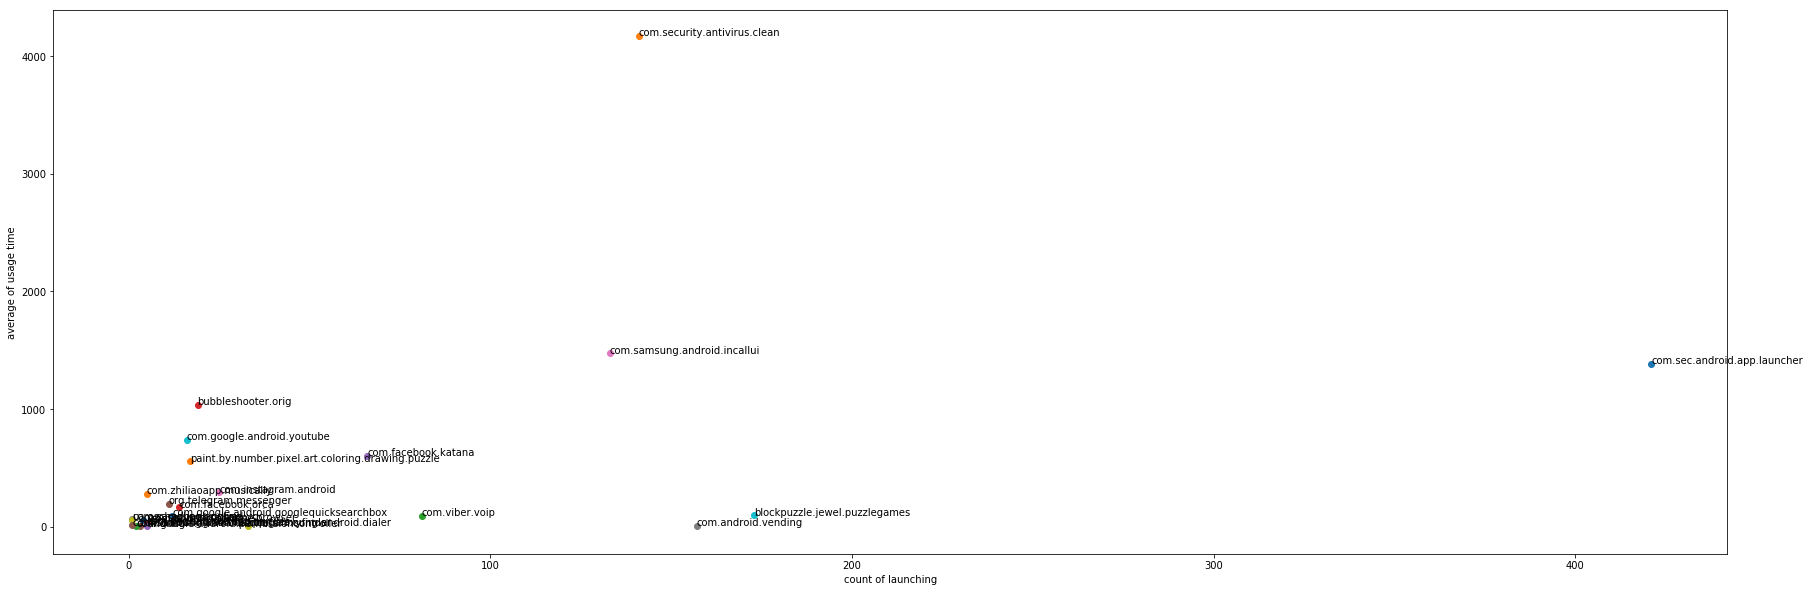

,count of launching,mean of usage time,median of usage time,status
com.sec.android.app.launcher,421,1385,7360,Not matched
blockpuzzle.jewel.puzzlegames,173,96,102,Not matched
com.android.vending,157,6,2,Not matched
com.security.antivirus.clean,141,4172,62,Not matched
com.samsung.android.incallui,133,1474,2000,Not matched
com.viber.voip,81,94,11,Not matched
com.facebook.katana,66,605,1250,Not matched
com.samsung.android.dialer,33,8,1,Not matched
com.instagram.android,25,293,144,Not matched
bubbleshooter.orig,19,1036,1331,Not matched


In [43]:
lines = ssrm.file_lines
package_lines = grep(lines,['PKG', 'LCD'], 1, show=False)

packages_number = dict()
packages_runing_time = dict()

pre_time = 0

for package_line in package_lines:
    time = GetTime(package_line, 'SSRM')
    #print(time)
    if pre_time > 0:
        packages_number[pre_package][0] += 1
        if time > pre_time:
            packages_runing_time[pre_package].append((time - pre_time) / 1000)
        else:
            packages_runing_time[pre_package].append(0)
        
    if 'PKG' in package_line and 'OVHT_TYPE' not in package_line:
        package = package_line[26:]
        if ' ' in package:
            package = package.split(' ')[0]
        if not package in packages_number:
            packages_number[package] = [0]
            packages_runing_time[package] = list()
            
        pre_package = package
        pre_time = time


plt.figure(figsize=(30,10))

dexopt_lines = lp.log_sections['SERVICE package']
status_lines = grep(dexopt_lines,['status='], -2, show=False)

max_number_of_columns = 0
for package in packages_number:
    if packages_number[package][0] != 0:
        avg_launching = np.sum(packages_runing_time[package]) / packages_number[package][0]
    else:
        avg_launching = 0
    plt.text(packages_number[package][0], avg_launching, package)
    plt.scatter(packages_number[package][0], avg_launching)
    packages_number[package].append(avg_launching)

    if len(packages_runing_time[package]) > 0:
        median_launching = packages_runing_time[package][packages_number[package][0] / 2]
    else:
        median_launching = 0
    packages_number[package].append(median_launching)
    package_status = grep(status_lines,[package], 3, show=False)
    
    flag = False
    for line in package_status:
        if 'status=' in line:
            splited = line.split(' ')
            packages_number[package].append(splited[1])
            flag = True
            break
    if flag is False:
        packages_number[package].append('Not matched')
plt.xlabel('count of launching')
plt.ylabel('average of usage time')
#plt.xlim(0, 100)
plt.show()
    
df = pd.DataFrame.from_dict(packages_number, orient='index', columns=['count of launching', 'mean of usage time', 'median of usage time', 'status'])
df = df.sort_values(by=['count of launching'], ascending=False)
display(df.head(50))

* Explain of auto_disabler<br>
앱 자동 초절전 기능은 32일 이상 사용하지 않은 앱에 대하여, 앱이 bg 에 있을 때 disable 시키는 기능으로, 15일을 주기로 "초절전 후보 앱 (=32일 미사용 앱)"을 사용자에게 보여주고 disable 시킵니다.

In [44]:
lines = lp.log_sections['SYSTEM LOG']
auto_disabler_lines = grep(lines,['auto_disabler', 'PACKAGE_CHANGED'], 1,  show=False)

for line in auto_disabler_lines:
    if 'auto_disabler' in line:
        print('\033[41m' + line + '\033[0m')
    else:
        print(line)

04-26 19:44:55.768  1000 19639 19639 W LoadedApk: Slow system_server main thread handled for android.intent.action.PACKAGE_CHANGED took 399 ms, Receiver = com.android.server.job.JobSchedulerService$3@d56e223
04-26 19:45:01.366  1000 19639 19639 W LoadedApk: Slow system_server main thread handled for android.intent.action.PACKAGE_CHANGED took 423 ms, Receiver = com.android.server.job.JobSchedulerService$3@d56e223


# <span style="color:blue">[MEMORY]</span> 

In [45]:
meminfo_lines = lp.log_sections['SERVICE HIGH meminfo']
searchers = [': Native', ': System', ': Persistent', ': Persistent Service', ': Foreground', ': Visible', ': Perceptible', ': Perceptible Low', ': A Services', ': Previous', ': B Services', ': Picked', ': Seedbed', ': Cached']
High_meminfo = list()

for searcher in searchers:
    for meminfo_line in meminfo_lines:
        if searcher in meminfo_line:
            High_meminfo.append(meminfo_line)
            break
display(High_meminfo)

['    295,112K: Native\n',
 '    253,284K: System\n',
 '    406,376K: Persistent\n',
 '     71,920K: Persistent Service\n',
 '    161,660K: Foreground\n',
 '    295,540K: Visible\n',
 '    158,596K: Perceptible\n',
 '    199,388K: Perceptible Low\n',
 '     46,692K: A Services\n',
 '    252,428K: B Services\n',
 '    112,836K: Picked\n',
 '    382,984K: Cached\n']

* If swap size of an item is large, there is a possiblity to have a memory leak problem.
* If count of cached items is under 3 or missing, there is a possiblity to have a higher memory pressure problem.

In [46]:
meminfo_lines = lp.log_sections['SERVICE HIGH meminfo']
TotalPSSs = grep(meminfo_lines,['Total PSS by process'], 5, show=False)
for TotalPSS in TotalPSSs:
    if 'swap' in TotalPSS:
        splited = TotalPSS.split('K')
        size_of_pss = (int)(splited[0].replace(',', ''))
        splited = splited[-2].split(' ')
        size_of_swap = (int)(splited[-1].replace(',', ''))
        percent_of_swap = size_of_swap * 100 / size_of_pss
        if percent_of_swap > 80:
            print('\033[31m{}  // {}% in swap, it needs to check the memory leak problem.\033[0m'.format(TotalPSS, percent_of_swap))
            continue
    print(TotalPSS)
print('          :')
tmp = grep(meminfo_lines,[': Picked'], 5)
print('          :')
tmp = grep(meminfo_lines,[': Cached'], 10)
print('          :')
tmp = grep(meminfo_lines,[': Perceptible'], 5)
print('          :')
tmp = grep(meminfo_lines,[': Persistent'], 5)
print('          :')
tmp = grep(meminfo_lines,[': Visible'], 5)

Total PSS by process:
259,378K: system (pid 19639)                                           (   63,058K in swap)
130,406K: com.android.systemui (pid 19908)                             (   64,442K in swap)
102,894K: com.samsung.android.voc (pid 17118 / activities)             (   16,143K in swap)
80,160K: surfaceflinger (pid 3684)                                    (    9,168K in swap)
          :
112,836K: Picked
49,808K: android.process.acore (pid 26085)
31,652K: com.samsung.cmh:CMH (pid 26972)
31,376K: android.process.media (pid 27069)
382,984K: Cached
58,492K: Picked                                                       (   32,409K in swap)
32,170K: android.process.acore (pid 26085)                            (   20,796K in swap)
13,402K: com.samsung.cmh:CMH (pid 26972)                              (    5,682K in swap)
12,920K: android.process.media (pid 27069)                            (    5,931K in swap)
152,871K: Cached                                                       (  

* Installing apps as multi uid (220406-02985)

 Line 582896:         200,160K: com.google.android.gms.persistent (pid 28632)<br>
 Line 582935:         156,024K: com.google.android.gms.persistent (pid 13858)<br>
 Line 582936:         155,824K: com.google.android.gms.persistent (pid 14127)<br>
 Line 582958:         223,700K: com.google.android.gms (pid 30553)<br>
 Line 582959:         160,380K: com.google.android.gms (pid 11913)<br>
 Line 582962:         143,720K: com.google.android.gms (pid 28484)<br>

In [47]:
lines = lp.log_sections['SERVICE HIGH meminfo']
TotalPSSs = grep(lines,['Total PSS by process'], 1000, show=False)

#display(TotalPSSs)

duplicated = dict()
lable = ""
for line in TotalPSSs:
    if 'Total PSS by category' in lable:
        break
    if ' by ' in line \
       or ': Native' in line \
       or ': Picked' in line \
       or ': Cached' in line \
       or ': Persistent' in line \
       or ': Foreground' in line \
       or ': Visible' in line \
       or ' Perceptible' in line \
       or ': Previous' in line \
       or ': Visible' in line:
        print(lable)
        lable = line
        print('\033[91m')
        for key in duplicated.keys():
            if len(duplicated[key]) > 1:
                print('[[[ ' + key + ' ]]]')
                for line in duplicated[key]:
                    print(line)
                print('')
        print('\033[0m')
        duplicated.clear()
        continue
    trimed = re.sub(' +', ' ', line)
    splited = trimed.split(' ')
    
    if len(splited) > 1:
        if splited[1] not in duplicated:
            duplicated[splited[1]] = list()
        
        duplicated[splited[1]].append(line)
        
    #print(TotalPSS)






Total PSS by process:

[[[ init ]]]
3,783K: init (pid 1)                                                 (    2,296K in swap)
1,662K: init (pid 2686)                                              (    1,628K in swap)

[[[ usap32 ]]]
3,525K: usap32 (pid 18750)                                           (    3,225K in swap)
3,480K: usap32 (pid 17662)                                           (    3,204K in swap)


Total PSS by OOM adjustment:


298,700K: Native                                                       (  172,048K in swap)

[[[ init ]]]
3,783K: init (pid 1)                                                 (    2,296K in swap)
1,662K: init (pid 2686)                                              (    1,628K in swap)

[[[ usap32 ]]]
3,525K: usap32 (pid 18750)                                           (    3,225K in swap)
3,480K: usap32 (pid 17662)                                           (    3,204K in swap)


273,172K: Persistent                                                

* Example

** MEMINFO in pid 22996 [cheehoon.ha.particulateforecaster] **<br>
                   Pss      Pss   Shared  Private   Shared  Private  SwapPss      Rss     Heap     Heap     Heap<br>
                 Total    Clean    Dirty    Dirty    Clean    Clean    Dirty    Total     Size    Alloc     Free<br>
                ------   ------   ------   ------   ------   ------   ------   ------   ------   ------   ------<br>
  Native Heap    29394        0      548    29392       52        0    96613    29992   171188   101061    66689<br>
  Dalvik Heap    15436        0      392    15432       92        0    20491    15916    45844    37652     8192<br>
 Dalvik Other     9230        0     2960     7892      212        0      500    11064<br>
        Stack     1304        0       12     1304        0        0     3164     1316<br>
       Ashmem        0        0        0        0       16        0        0       16<br>
    Other dev       60        0      312       48       60       12        0      432<br>
     .so mmap      423        0      848      108    17060        0      196    18016<br>
    .jar mmap      476      124        0        0    18968      124        8    19092<br>
    .apk mmap     6248     3180        0       12    18872     3180      240    22064<br>
    .ttf mmap        0        0        0        0        4        0        0        4<br>
    .dex mmap     4020     3384        0        0     2700     3384       96     6084<br>
    .oat mmap      169        0        8        0     9492        0        0     9500<br>
    .art mmap     1970       16    14208     1756     3744       16      708    19724<br>
   Other mmap      272        0        4       32     1080       20        8     1136<br>
    GL mtrack   224525        0        0   224525        0        0        0   224525                           <span style="color:red">=> Over usage of graphic memory</span> <br>
      Unknown     1040        0      104     1040       60        0      754     1204<br>
        TOTAL   417345     6704    19396   281541    72412     6736   122778   380085   217032   138713    74881<br> 

In [48]:
high_meminfo = lp.log_sections['SERVICE HIGH meminfo']
lines = grep(high_meminfo,['MEMINFO in'], 80, show=False)
count = 0
OverMemUsages = grep(TotalPSSs,['[5-9][0-9][0-9],'], 1, show=False)
OverMemUsageProcesses = list()

for line in OverMemUsages:
    splited_line = line.split(' ')
    if len(splited_line) > 1 :
        OverMemUsageProcesses.append('[' + splited_line[1] + ']')
print(OverMemUsageProcesses)

for line in lines:
    if 'MEMINFO in' in line:
        for OverMemUsageProcess in OverMemUsageProcesses:
            if OverMemUsageProcess in line:
                print('\n===================================================================================================================\n')
                count = 80
    if count > 0 :
        print(line)
        count -= 1

['[RAM:]', '[RAM:]', '[]']


 App Summary<br>
                       Pss(KB)                        Rss(KB)<br>
                        ------                         ------<br>
           Java Heap:   257652                         276248<br>
         Native Heap:    58024                          58556<br>
                Code:     4908                          71016<br>
               Stack:      984                            992<br>
            Graphics:    51836                          51836<br>
       Private Other:     7772<br>
              System:  1625935<br>
             Unknown:                                    8804<br>
           TOTAL PSS:  2007111            TOTAL RSS:   467452       TOTAL SWAP PSS:  1619250<br>
 Objects<br>
               Views:    62516         ViewRootImpl:        0                     <span style="color:red">=> Over usage of views</span><br>
         AppContexts:      598           Activities:      195<br>
              Assets:       18        AssetManagers:        0<br>
       Local Binders:     1029        Proxy Binders:      258<br>
       Parcel memory:    35514         Parcel count:    16702<br>
    Death Recipients:        2      OpenSSL Sockets:        0<br>
            WebViews:        0 <br>

* <span style="color:red">If the number of views or viewrootimple has big size, it should be a memory leak problem.</span>

In [49]:
high_meminfo = lp.log_sections['SERVICE HIGH meminfo']
lines = grep(high_meminfo,['MEMINFO in'], 80, show=False)

MEMINFO = list()
for line in lines:
    if 'MEMINFO in' in line:
        del MEMINFO[:]
        MEMINFO = list()
        MEMINFO.append(line)
    
    if 'Views:' in line and 'ViewRootImpl:' in line:
        MEMINFO.append(line)
        number_of_view = re.sub(' +', ' ', line)
        number_of_view = number_of_view.split(' ')

        if int(number_of_view[1]) > 10000 or int(number_of_view[3]) > 10:
            print('')
            for meminfor_line in MEMINFO:
                print('\033[31m' + meminfor_line + '\033[0m')
            #display(MEMINFO)

------ MEMORY INFO (/proc/meminfo) ------<br>
MemTotal:        5545928 kB<br>
MemFree:          110876 kB<br>
MemAvailable:     688652 kB<br>
Buffers:           14184 kB<br>
Cached:           738220 kB<br>
SwapCached:        47320 kB<br>
Active:          1839524 kB<br>
Inactive:         727396 kB<br>
Active(anon):    1637060 kB<br>
Inactive(anon):   432852 kB<br>
Active(file):     202464 kB<br>
Inactive(file):   294544 kB<br>
Unevictable:        8068 kB<br>
Mlocked:            8068 kB<br>
RbinTotal:        233472 kB<br>
RbinAlloced:           0 kB<br>
RbinPool:              0 kB<br>
RbinFree:           6196 kB<br>
RbinCached:       226732 kB<br>
SwapTotal:       2621436 kB<br>
SwapFree:           6432 kB             <span style="color:red">=> If SwapFree was low, it should be checked by memory team.</span> <br>

Slab:            1362056 kB             <span style="color:red">=> This is example of slab memory leak</span><br>


------ MEMORY INFO (/proc/meminfo) ------
MemTotal:        1818908 kB
MemFree:           54460 kB
MemAvailable:     474204 kB
Buffers:           55168 kB
Cached:           444880 kB
SwapCached:        26336 kB
Active:           458700 kB
Inactive:         510732 kB
Active(anon):     222300 kB
Inactive(anon):   257124 kB
Active(file):     236400 kB
Inactive(file):   253608 kB
Unevictable:        2032 kB
Mlocked:            2032 kB
SwapTotal:       1342460 kB
SwapFree:         540528 kB
Dirty:               616 kB
Writeback:             0 kB
AnonPages:        466304 kB
Mapped:           201928 kB
Shmem:              8648 kB
Slab:             171480 kB
SReclaimable:      47972 kB
SUnreclaim:       123508 kB
KernelStack:       39456 kB
PageTables:        49580 kB
NFS_Unstable:          0 kB
Bounce:                0 kB
WritebackTmp:          0 kB
CommitLimit:     2251912 kB
Committed_AS:   43560956 kB
VmallocTotal:   258867136 kB
VmallocUsed:           0 kB
VmallocChunk:          0 kB
CmaTo

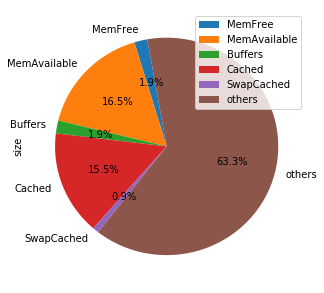

In [50]:
memory_infors = lp.log_sections['MEMORY INFO'][:38]
MemTotal = 0
Slab = 0

for memory_infor in memory_infors:
    if 'MemTotal:' in memory_infor:
        splited = memory_infor.split(' ')
        MemTotal = int(splited[-2])

    if 'SwapFree:' in memory_infor:
        splited = memory_infor.split(' ')
        if int(splited[-2]) < 7000:
            print('\033[44m' + '\033[41m' + '{}     // SwapFree is low'.format(memory_infor[:-1]) + '\033[0m')
            continue

    if 'Shmem:' in memory_infor:
        splited = memory_infor.split(' ')
        if int(splited[-2]) > 1000000:
            print('\033[44m' + '\033[41m' + '{}     // Shared memory should has a leak problem.'.format(memory_infor[:-1]) + '\033[0m')
            continue

    if 'Slab:' in memory_infor:
        splited = memory_infor.split(' ')
        Slab = int(splited[-2])
        
        if Slab > 1000000:
            print('\033[41m' + '{}     // 1000000 Kb over, a slab memory leak problem can be questioned'.format(memory_infor[:-1]) + '\033[0m')
            continue
        if Slab > 500000:
            print('\033[31m' + '{}     // 500000 Kb over, a slab memory leak problem can be questioned'.format(memory_infor[:-1]) + '\033[0m')
            continue
        if Slab > 300000:
            print('\033[91m' + '{}     // 300000 Kb over, a slab memory leak problem can be questioned'.format(memory_infor[:-1]) + '\033[0m')
            continue 
    print(memory_infor[:-1])

data = list()
sum = 0

for i in range(2,7):
    splited = lp.log_sections['MEMORY INFO'][i].split(':')
    size = int(splited[1].split('kB')[0])
    data.append([splited[0], size])
    sum += size

splited = lp.log_sections['MEMORY INFO'][1].split(':')
total = int(splited[1].split('kB')[0])
data.append(['others', total])

df = pd.DataFrame(data, columns=['id', 'size'])
df = df.set_index('id')

df.plot.pie(y='size',figsize=(5, 5), autopct='%1.1f%%', startangle=100)

plt.show()

09-02 15:40:31.760  lmkd   694   694 I killinfo: [8639,10397,985,850,93072,3,256564,883228,1073936,53420,2804,80732,6900,512000,512000,0,0,4194300,145860,1358660,1380248,417224,576228,97<br>

* minfree : 256564 <br>
* availablemem : 883228 <br>
* cachemem : 1073936 <br>
* buffer : 53420 <br>
* shared mem : 6900 <br>

In [51]:
lines = lp.log_sections['EVENT LOG']
killinfos = grep(lines,['killinfo'], 1)

04-26 19:33:46.492  lmkd  3395  3395 I killinfo: [29084,1000,500,0,48380,-1,51152,320404,322208,18804,28860,7988,2032,0,0,0,0,1342460,390120,218200,216480,170112,170992,0,44796,122372,39120,48176,0,0,0,0,0,108,0,0,49]
04-26 19:33:49.191  lmkd  3395  3395 I killinfo: [29262,10015,905,850,66996,-1,50064,297340,301500,19308,26908,8088,2032,0,0,0,0,1342460,384884,228580,227796,159188,159852,0,44976,122396,40112,49172,0,0,0,0,0,640,0,0,49]
04-26 19:34:00.103  lmkd  3395  3395 I killinfo: [29410,10042,915,850,45800,-1,50372,292424,305372,17964,18028,7644,2032,0,0,0,0,1342460,351096,219688,231632,158272,156176,0,43712,122316,40256,50800,0,0,0,0,0,6712,0,0,49]
04-26 19:34:00.261  lmkd  3395  3395 I killinfo: [29432,10042,905,850,44824,-1,50760,293228,305804,18068,18004,7668,2032,0,0,0,0,1342460,354496,219800,231416,166028,148712,0,43712,122316,40064,50084,0,0,0,124,0,124,0,0,49]
04-26 19:34:07.364  lmkd  3395  3395 I killinfo: [29539,10050,905,850,40892,-1,50300,187924,204556,18520,14888,7908,

In [52]:
killinfo_dict = dict()
count = 0

for killinfo in killinfos:
    splited = killinfo.split('[')
    time = splited[0].split(' ')
    if len(splited) > 1:
        splited = splited[1].split(']')
        if len(splited) > 0:
            splited = splited[0].split(',')
            killinfo_dict[time[1]] = splited
            count = len(splited)

subtitle = list()
for i in range(count):
    subtitle.append('-')
    
if len(subtitle) > 12:
    subtitle[6] = 'minfree'
    subtitle[7] = 'available mem'
    subtitle[8] = 'cache mem'
    subtitle[9] = 'buffer'
    subtitle[12] = 'shared mem'
    #subtitle = ['-','-','-','-','-','-','minfree','available mem','cache mem','buffer','-','-','shared mem','-','-','-','-','-','-','-','-','-','-','-','-','-','-','-','-','-','-','a','a','a','a','a','a','a','a']
    df = pd.DataFrame.from_dict(killinfo_dict, orient='index', columns=subtitle)
    pd.set_option('display.max_columns',500)
    pd.set_option('display.max_rows',500)
    display(df.sort_index())

,-,-,-,-,-,-,minfree,available mem,cache mem,buffer,-,-,shared mem,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-
19:33:46.492,29084,1000,500,0,48380,-1,51152,320404,322208,18804,28860,7988,2032,0,0,0,0,1342460,390120,218200,216480,170112,170992,0,44796,122372,39120,48176,0,0,0,0,0,108,0,0,49
19:33:49.191,29262,10015,905,850,66996,-1,50064,297340,301500,19308,26908,8088,2032,0,0,0,0,1342460,384884,228580,227796,159188,159852,0,44976,122396,40112,49172,0,0,0,0,0,640,0,0,49
19:34:00.103,29410,10042,915,850,45800,-1,50372,292424,305372,17964,18028,7644,2032,0,0,0,0,1342460,351096,219688,231632,158272,156176,0,43712,122316,40256,50800,0,0,0,0,0,6712,0,0,49
19:34:00.261,29432,10042,905,850,44824,-1,50760,293228,305804,18068,18004,7668,2032,0,0,0,0,1342460,354496,219800,231416,166028,148712,0,43712,122316,40064,50084,0,0,0,124,0,124,0,0,49
19:34:07.364,29539,10050,905,850,40892,-1,50300,187924,204556,18520,14888,7908,2032,0,0,0,0,1342460,361212,235048,245048,103824,106340,0,43180,122168,40848,50436,0,0,0,120,0,976,0,0,49
19:34:07.477,29133,5010,800,0,70024,-1,49432,185880,203044,18424,14676,7892,2032,0,0,0,0,1342460,366592,237204,244576,113684,95424,0,43180,122168,40608,49728,0,0,0,0,0,4,0,0,49
19:34:33.672,29362,10153,915,850,91764,-1,50552,212812,228068,18404,16452,8196,2032,0,0,0,0,1342460,380048,233580,232824,118932,115968,0,43220,122196,39936,48800,0,0,0,0,0,25003,0,0,49
19:34:34.092,29179,10078,905,850,75232,-1,50180,224100,239164,18420,16860,8016,2032,0,0,0,0,1342460,379704,222624,232532,120508,126052,0,43220,122208,39808,49012,0,0,0,0,0,416,0,0,49
19:34:35.437,29214,1000,800,0,47528,-1,49080,224948,242060,18468,15536,8024,2032,0,0,0,0,1342460,375496,226576,226392,126860,121304,0,43220,122232,40000,49320,0,0,0,344,0,8,0,0,49
19:34:35.468,28492,10151,500,0,70432,-1,49720,225208,241672,18472,15548,8020,2032,0,0,0,0,1342460,375368,225892,225576,126672,121152,0,43220,122232,39904,49292,0,0,0,304,0,12,0,0,49


In [53]:
lines = lp.log_sections['EVENT LOG']
am_app_dieds = grep(lines,['am_proc_died'], 1)

04-26 19:33:46.525  1000 19639 20303 I am_proc_died: [0,29084,android:drmService,3,500,10,54,312]
04-26 19:33:49.234  1000 19639 21248 I am_proc_died: [0,29262,com.samsung.android.mobileservice,3,905,19,64,293]
04-26 19:34:00.123  1000 19639 19653 I am_proc_died: [0,29410,com.google.process.gapps,3,915,19,52,297]
04-26 19:34:00.285  1000 19639 21253 I am_proc_died: [0,29432,com.google.process.gservices,3,905,19,53,297]
04-26 19:34:07.386  1000 19639 19653 I am_proc_died: [0,29539,com.sec.android.app.soundalive,3,905,19,52,199]
04-26 19:34:07.509  1000 19639 21261 I am_proc_died: [0,29133,com.samsung.android.rubin.app,3,800,10,61,198]
04-26 19:34:33.715  1000 19639 20300 I am_proc_died: [0,29362,com.sec.android.app.sbrowser,3,915,19,74,222]
04-26 19:34:34.137  1000 19639 21255 I am_proc_died: [0,29179,com.osp.app.signin,3,905,19,70,233]
04-26 19:34:35.467  1000 19639 21255 I am_proc_died: [0,29214,android:drmService,3,800,10,50,236]
04-26 19:34:35.511  1000 19639 20301 I am_proc_died: [

Text(0.5,1,'OOM ADJ(AM_PROC_DIED)')

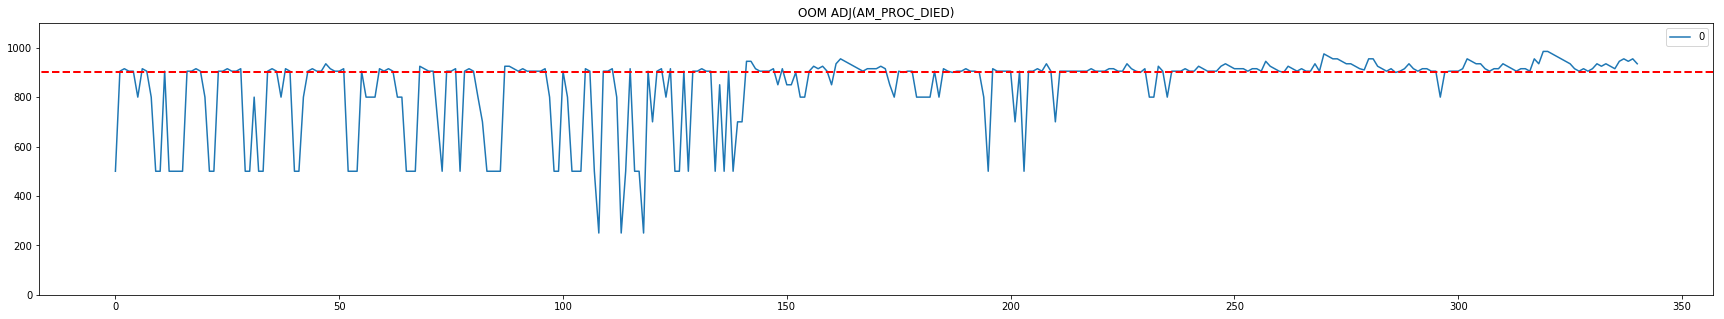

In [54]:
am_app_dieds_mem = list()
oom_adj = 0

for am_app_died in am_app_dieds:
    splited = am_app_died.split(',')
    pre_oom_adj = oom_adj
    oom_adj = int(splited[4])
    if oom_adj == 0 :
        oom_adj = pre_oom_adj
    am_app_dieds_mem.append(oom_adj)
    if oom_adj < 200 :
        print(am_app_died)
#print(am_app_dieds_mem)
df = pd.DataFrame(am_app_dieds_mem)
ax = df.plot(figsize=(30,5), ylim=(0, 1100))
ax.axhline(y=900, xmin=-1, xmax=1, color='r', linestyle='--', lw=2)
ax.set_title('OOM ADJ(AM_PROC_DIED)')

In [55]:
lines = lp.log_sections['SYSTEM LOG']
killinfos = grep(lines,['Reclaim'], 1)

04-26 19:45:42.791  lmkd  3395  3395 I lmkd    : Reclaim 'android:drmService' (9632), uid 1000, oom_adj 800, state 10 to free 44188kB
04-26 19:45:42.791  lmkd  3395  3395 I lmkd    : Reclaimed 44188kB at oom_adj 0
04-26 19:45:44.613  lmkd  3395  3395 I lmkd    : Reclaimed 0kB at oom_adj 850
04-26 19:45:46.022  lmkd  3395  3395 I lmkd    : Reclaim 'com.google.process.gservices' (10966), uid 10042, oom_adj 925, state 19 to free 45140kB
04-26 19:45:46.022  lmkd  3395  3395 I lmkd    : Reclaimed 45140kB at oom_adj 850
04-26 19:45:46.548  lmkd  3395  3395 I lmkd    : Reclaim 'com.facebook.katana' (11834), uid 10161, oom_adj 905, state 19 to free 73292kB
04-26 19:45:46.548  lmkd  3395  3395 I lmkd    : Reclaimed 73292kB at oom_adj 850
04-26 19:45:46.584  lmkd  3395  3395 I lmkd    : Reclaim 'com.osp.app.signin' (9918), uid 10078, oom_adj 800, state 10 to free 49312kB
04-26 19:45:46.584  lmkd  3395  3395 I lmkd    : Reclaimed 49312kB at oom_adj 0
04-26 19:45:47.581  lmkd  3395  3395 I lmkd   

04-26 19:33:46.525  1000 19639 20303 I am_proc_died: [0,29084,android:drmService,3,500,10,54,312]
04-26 19:33:49.234  1000 19639 21248 I am_proc_died: [0,29262,com.samsung.android.mobileservice,3,905,19,64,293]
04-26 19:34:00.123  1000 19639 19653 I am_proc_died: [0,29410,com.google.process.gapps,3,915,19,52,297]
04-26 19:34:00.285  1000 19639 21253 I am_proc_died: [0,29432,com.google.process.gservices,3,905,19,53,297]
04-26 19:34:07.386  1000 19639 19653 I am_proc_died: [0,29539,com.sec.android.app.soundalive,3,905,19,52,199]
04-26 19:34:07.509  1000 19639 21261 I am_proc_died: [0,29133,com.samsung.android.rubin.app,3,800,10,61,198]
04-26 19:34:33.715  1000 19639 20300 I am_proc_died: [0,29362,com.sec.android.app.sbrowser,3,915,19,74,222]
04-26 19:34:34.137  1000 19639 21255 I am_proc_died: [0,29179,com.osp.app.signin,3,905,19,70,233]
04-26 19:34:35.467  1000 19639 21255 I am_proc_died: [0,29214,android:drmService,3,800,10,50,236]
04-26 19:34:35.511  1000 19639 20301 I am_proc_died: [

Text(0.5,1,'FREE MEMORY(AM_PROC_DIED)')

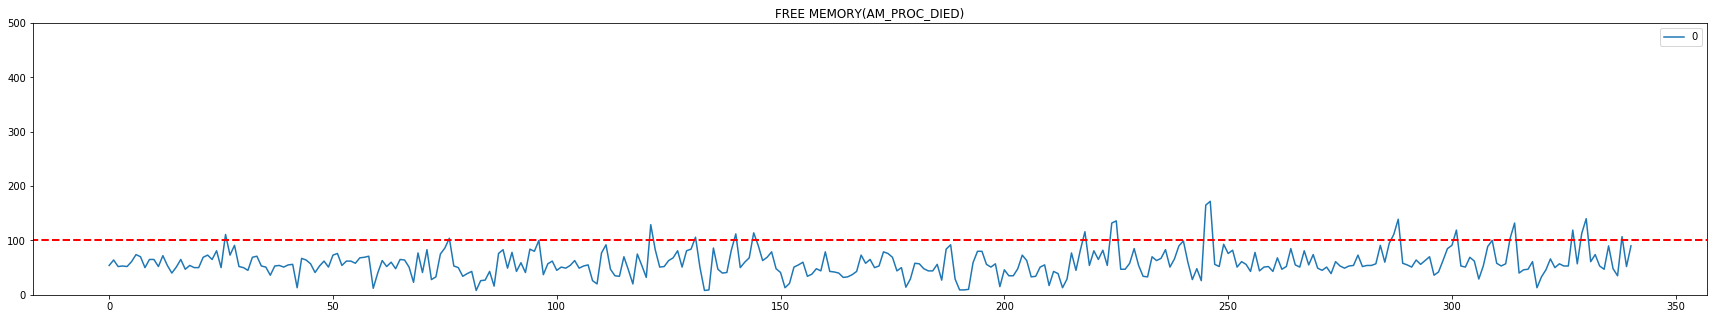

In [56]:
am_app_dieds_mem = list()

for am_app_died in am_app_dieds:
    splited = am_app_died.split(',')
    am_app_dieds_mem.append(int(splited[-2]))
    if int(splited[-2]) < 100:
        print(am_app_died)
#print(am_app_dieds_mem)
df = pd.DataFrame(am_app_dieds_mem)
ax = df.plot(figsize=(30,5), ylim=(0,500))
ax.axhline(y=100, xmin=-1, xmax=1, color='r', linestyle='--', lw=2)
ax.set_title('FREE MEMORY(AM_PROC_DIED)')

* If file cache size is smaller then 200, it can make some sluggish problem(in some scenario, likes take a picture with camera app).

04-26 19:33:46.525  1000 19639 20303 I am_proc_died: [0,29084,android:drmService,3,500,10,54,312]
04-26 19:33:49.234  1000 19639 21248 I am_proc_died: [0,29262,com.samsung.android.mobileservice,3,905,19,64,293]
04-26 19:34:00.123  1000 19639 19653 I am_proc_died: [0,29410,com.google.process.gapps,3,915,19,52,297]
04-26 19:34:00.285  1000 19639 21253 I am_proc_died: [0,29432,com.google.process.gservices,3,905,19,53,297]
04-26 19:34:07.386  1000 19639 19653 I am_proc_died: [0,29539,com.sec.android.app.soundalive,3,905,19,52,199]
04-26 19:34:07.509  1000 19639 21261 I am_proc_died: [0,29133,com.samsung.android.rubin.app,3,800,10,61,198]
04-26 19:34:33.715  1000 19639 20300 I am_proc_died: [0,29362,com.sec.android.app.sbrowser,3,915,19,74,222]
04-26 19:34:34.137  1000 19639 21255 I am_proc_died: [0,29179,com.osp.app.signin,3,905,19,70,233]
04-26 19:34:35.467  1000 19639 21255 I am_proc_died: [0,29214,android:drmService,3,800,10,50,236]
04-26 19:34:35.511  1000 19639 20301 I am_proc_died: [

Text(0.5,1,'FILE CACHE MEMORY(AM_PROC_DIED)')

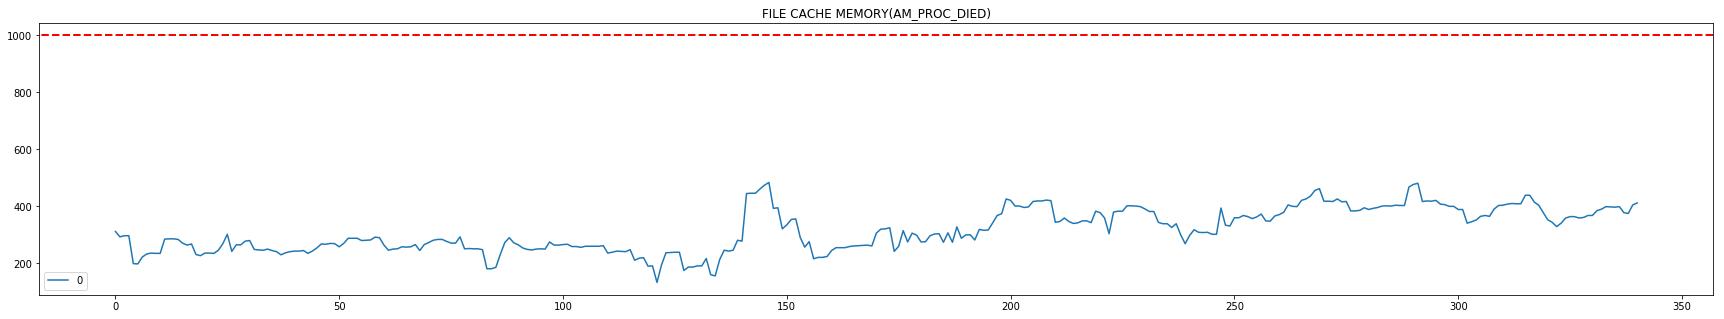

In [57]:
am_app_dieds_mem = list()

for am_app_died in am_app_dieds:
    splited = am_app_died.split(',')
    am_app_dieds_mem.append(int(splited[-1][:-1]))
    if int(int(splited[-1][:-1])) < 1000:
        print(am_app_died)
#print(am_app_dieds_mem)
df = pd.DataFrame(am_app_dieds_mem)
ax = df.plot(figsize=(30,5))
ax.axhline(y=1000, xmin=-1, xmax=1, color='r', linestyle='--', lw=2)
ax.set_title('FILE CACHE MEMORY(AM_PROC_DIED)')

In [58]:
lines = lp.log_sections['SYSTEM LOG']
tmp = grep(lines,['WaitForGcToComplete blocked', 'Waiting for a blocking GC Alloc'], 1)

04-26 19:45:44.357 10285  9868 11544 I com.viber.voip: WaitForGcToComplete blocked ProfileSaver on ClassLinker for 1.070s
04-26 19:45:44.525 10285  9868 11535 I com.viber.voip: WaitForGcToComplete blocked RunEmptyCheckpoint on ProfileSaver for 140.621ms
04-26 19:45:46.620 10165 11731 11854 I stagram.androi: WaitForGcToComplete blocked Debugger on AddRemoveAppImageSpace for 200.665ms
04-26 19:45:48.378 10015 11749 11789 I d.mobileservic: WaitForGcToComplete blocked ProfileSaver on AddRemoveAppImageSpace for 29.654ms
04-26 19:45:48.429 10015 11749 11769 I d.mobileservic: WaitForGcToComplete blocked RunEmptyCheckpoint on ProfileSaver for 31.381ms
04-26 19:45:49.965 10165 11731 11790 I stagram.androi: WaitForGcToComplete blocked ProfileSaver on Debugger for 1.588s
04-26 19:45:50.107 10165 11731 11883 I stagram.androi: WaitForGcToComplete blocked ClassLinker on ProfileSaver for 1.442s
04-26 19:45:50.109 10165 11731 11744 I stagram.androi: WaitForGcToComplete blocked RunEmptyCheckpoint on Cl

In [59]:
lines = lp.log_sections['EVENT LOG']
am_app_pss_lines = grep(lines,['am_pss', 'am_on_top_resumed_gained_called'], 1, show=False)

for am_app_pss_line in am_app_pss_lines:
    if 'am_pss' in am_app_pss_line:
        am_app_pss_line_splited = am_app_pss_line.split(',')
        if len(am_app_pss_line_splited) > 7:
            pss = am_app_pss_line_splited[-7]
            pss_MB = int(pss) / 1024 / 1024
            if (pss_MB > 500) :
                print("\n" + am_app_pss_line + "\t\t\t\t\t// ========================> PSS : " + str(pss_MB) + " MB  by " + am_app_pss_line_splited[2] + " <========================\n")
            elif (pss_MB > 50) :
                print(am_app_pss_line + "\t\t\t\t\t// PSS : " + str(pss_MB) + " MB  by " + am_app_pss_line_splited[2])
    else:
        print(am_app_pss_line)

04-26 19:34:05.247  1000 19639 19663 I am_pss  : [24344,10020,com.android.vending,72258560,42139648,25254912,92229632,0,3,10]					// PSS : 68 MB  by com.android.vending
04-26 19:34:16.374  1000 19639 19663 I am_pss  : [11928,10240,blockpuzzle.jewel.puzzlegames,235141120,137347072,85363712,205512704,0,2,21]					// PSS : 224 MB  by blockpuzzle.jewel.puzzlegames
04-26 19:35:39.246  1000 19639 19663 I am_pss  : [28888,10156,org.telegram.messenger,57973760,38932480,12051456,93691904,0,8,10]					// PSS : 55 MB  by org.telegram.messenger
04-26 19:36:05.506  1000 19639 19663 I am_pss  : [28888,10156,org.telegram.messenger,58300416,26472448,24521728,80842752,0,8,9]					// PSS : 55 MB  by org.telegram.messenger
04-26 19:37:13.371  1000 19639 19663 I am_pss  : [30653,10156,org.telegram.messenger,58169344,51552256,649216,107638784,0,8,11]					// PSS : 55 MB  by org.telegram.messenger
04-26 19:37:38.552  1000 19639 19663 I am_pss  : [30653,10156,org.telegram.messenger,58391552,51527680,665600,10762

In [60]:
lines = lp.log_sections['SYSTEM LOG']
tmp = grep(lines,['Couldn\'t load memtrack module', 'failed to get memory consumption'], 1)

--- Nothing ---


* If heap free size is 0%, it doubts a memory leak problem.

In [61]:
lines = lp.log_sections['VM TRACES JUST NOW']
heap_lines = grep(lines,['Cmd line:', 'Heap:', 'Total GC', 'Total blocking GC'], 1, show=False)

printable = list()
flag_print = False
for heap_line in heap_lines:
    if 'Cmd line:' in heap_line:
        if flag_print:
            display(printable)
            flag_print = False
        del printable[:]
    printable.append(heap_line)
    if 'Total GC count' in heap_line and re.search('[1-9][0-9][0-9][0-9][0-9]', heap_line):
        flag_print = True
    if 'Heap:' in heap_line and re.search(' [0-9]%', heap_line):
        flag_print = True

['Cmd line: com.android.vending',
 'Heap: 9% free, 10MB/11MB; 187568 objects',
 'Total GC count: 8',
 'Total GC time: 5.317s',
 'Total blocking GC count: 1',
 'Total blocking GC time: 2.296s']

['Cmd line: com.samsung.android.honeyboard',
 'Heap: 6% free, 11MB/11MB; 248024 objects',
 'Total GC count: 40',
 'Total GC time: 29.481s',
 'Total blocking GC count: 1',
 'Total blocking GC time: 550.671ms']

['Cmd line: com.samsung.android.email.provider',
 'Heap: 7% free, 3486KB/3749KB; 82552 objects',
 'Total GC count: 9',
 'Total GC time: 1.597s',
 'Total blocking GC count: 1',
 'Total blocking GC time: 162.332ms']

['Cmd line: com.android.networkstack.process',
 'Heap: 8% free, 4451KB/4883KB; 94030 objects',
 'Total GC count: 433',
 'Total GC time: 49.459s',
 'Total blocking GC count: 0',
 'Total blocking GC time: 0']

['Cmd line: com.android.bluetooth',
 'Heap: 9% free, 3836KB/4248KB; 86540 objects',
 'Total GC count: 36',
 'Total GC time: 6.203s',
 'Total blocking GC count: 0',
 'Total blocking GC time: 0']

['Cmd line: android.process.acore',
 'Heap: 9% free, 3077KB/3398KB; 81067 objects',
 'Total GC count: 2967',
 'Total GC time: 504.986s',
 'Total blocking GC count: 0',
 'Total blocking GC time: 0']

['Cmd line: com.google.android.gms.persistent',
 'Heap: 3% free, 27MB/28MB; 498969 objects',
 'Total GC count: 165',
 'Total GC time: 76.836s',
 'Total blocking GC count: 1',
 'Total blocking GC time: 873.361ms']

In [62]:
lines = lp.log_sections['LOG STATISTICS']
tmp = grep(lines,['ring buffer is'], 1)

main: ring buffer is 1 MiB (977 KiB consumed), max entry is 5120 B, max payload is 4068 B
radio: ring buffer is 512 KiB (503 KiB consumed), max entry is 5120 B, max payload is 4068 B
events: ring buffer is 256 KiB (251 KiB consumed), max entry is 5120 B, max payload is 4068 B
system: ring buffer is 512 KiB (492 KiB consumed), max entry is 5120 B, max payload is 4068 B
crash: ring buffer is 256 KiB (0 B consumed), max entry is 5120 B, max payload is 4068 B
stats: ring buffer is 64 KiB (0 B consumed), max entry is 5120 B, max payload is 4068 B
security: ring buffer is 256 KiB (0 B consumed), max entry is 5120 B, max payload is 4068 B
kernel: ring buffer is 256 KiB (0 B consumed), max entry is 5120 B, max payload is 4068 B


* Delay of ION allocation for Camera (100 < duration < 250)

In [63]:
lines = lp.log_sections['SYSTEM LOG']
ION_allocation_lines = grep(lines,['DEBUG:duration time'], 1, show=False)
for ION_allocation_line in ION_allocation_lines:
    if re.search('[0-9][0-9][0-9] msec', ION_allocation_line) or re.search('[0-9][0-9][0-9][0-9] msec', ION_allocation_line):
        print(ION_allocation_line)

--- Nothing ---


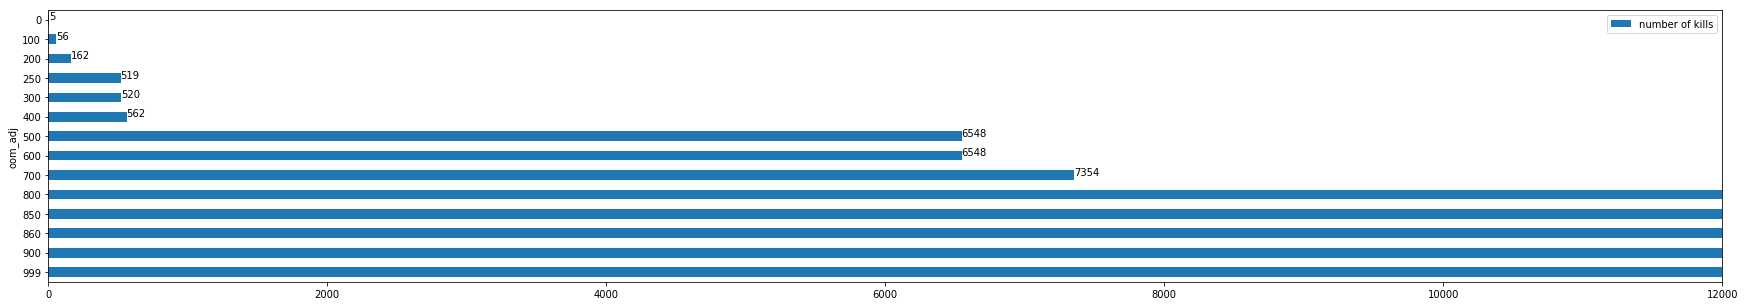

In [64]:
lines = lp.log_sections['ACTIVITY MANAGER LMK KILLS']
oom_adj_lines = grep(lines,['oom_adj'], 1, show=False)

if len(oom_adj_lines) > 0:
    lmk_kills = dict()
    lmk_kills['oom_adj'] = list()
    lmk_kills['number of kills'] = list()

    for oom_adj_line in oom_adj_lines:
        splited = oom_adj_line.split(' ')
        lmk_kills['oom_adj'].append(int(splited[-2][:-1]))
        lmk_kills['number of kills'].append(int(splited[-1]))

    df = pd.DataFrame.from_dict(lmk_kills)
    df.set_index('oom_adj', inplace=True)
    #df.sort_index(ascending=False)

    ax = df.plot(kind='barh', figsize=(30,5), xlim=(0,12000))
    for index, value in enumerate(df['number of kills']):
        if value > 0 and value < 12000:
            ax.text(value, index, str(value))
    plt.show()

* HeapTaskDaemon

<6>[51056.032367] [4:pool-42-thread-: 2960] heaviest_task_rss:.mobile.pguidea(28116) size:375680KB, totalram_pages:6480004KB

In [65]:
lines = lp.log_sections['SEC LOG']
lines += lp.log_sections['KERNEL LOG']
#display(lp.log_sections['SEC LOG'])
tmp = grep(lines,['heaviest_task_rss'], 1, show=True)

--- Nothing ---
